# Goals for this model

Given a dataset of movie features, try to predict a movie's IMDB score before it is released.

# Todo List

- [ ] test this script on predicting budget rather than score. do the results match moy's? is it easy to change the outcome variable?
- [ ] apply GridSearchCV to each model
- [ ] apply automated feature selection to each model (backward elimination, forward selection)
- [ ] make normalization work for regression models (now that we have models other than linear regression we need it)
- [X] collect each models' regression statistics into a dataframe for comparing models
- [ ] make many predictions and store results in a dataframe for comparing results (e.g. optimal runtime for horror movies is x )
- [ ] roll in the preprocessing steps to 
  - [ ] handle missing values
  - [X] cleanse data (e.g. parse country and release date, append release year to name)
  - [X] split data into new columns (release date to release year, month, day, etc.)

# About the Data

### Movie Industry | Four decades of movies

[via Daniel Grijalva on Kaggle](https://www.kaggle.com/danielgrijalvas/movies)

#### Context

Is the movie industry dying? is Netflix the new entertainment king? Those were the first questions that lead me to create a dataset
focused on movie revenue and analyze it over the last decades. But, why stop there? There are more factors that intervene in this
kind of thing, like actors, genres, user ratings and more. And now, anyone with experience (you) can ask specific questions about the
movie industry, and get answers.

#### Content

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

- budget: the budget of a movie. Some movies don't have this, so it appears as 0
- company: the production company
- country: country of origin
- director: the director
- genre: main genre of the movie.
- gross: revenue of the movie
- name: name of the movie
- rating: rating of the movie (R, PG, etc.)
- released: release date (YYYY-MM-DD)
- runtime: duration of the movie
- score: IMDb user rating
- votes: number of user votes
- star: main actor/actress
- writer: writer of the movie
- year: year of release

### Acknowledgements

This data was scraped from IMDb.

# Imports

In [804]:
from pathlib import Path

import pandas as pd
import numpy as np
from patsy import dmatrices # https://pypi.org/project/patsy/

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor #Multi-layer Perceptron (not very powerful)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import explained_variance_score as explained_var, mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Collection of utility functions used in the book
# Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python (First Edition)
# Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel (c) 2019 John Wiley & Sons, Inc.
#
# Published under MIT License
# https://pypi.org/project/dmba/
# https://www.dataminingbook.com/book/python-edition.
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import backward_elimination, forward_selection, stepwise_selection, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score


# Base Inputs

In [805]:
# input definitions
fPath = '../../_data/_processed/'
fName = 'processed_for_viz.csv' # preprocessing already done
fName = 'BudgetImputed.csv' # output from Moy's processing script
#fPath = '../../_data/_raw/'
#fName = 'movies.csv'
file = (fPath + fName) # preprocessing already done
continuous = True
outcome_var_name = 'score'


# Read Data

In [806]:
# get data
df = pd.read_csv(fPath + fName)

# Basic Data Exploration

In [807]:
print('First few rows')
df.head(10)

First few rows


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0
6,The Blues Brothers,R,Action,1980,"June 20, 1980 (United States)",7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,115229890.0,Universal Pictures,133.0
7,Raging Bull,R,Biography,1980,"December 19, 1980 (United States)",8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,18000000.0,23402427.0,Chartoff-Winkler Productions,129.0
8,Superman II,PG,Action,1980,"June 19, 1981 (United States)",6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000.0,108185706.0,Dovemead Films,127.0
9,The Long Riders,R,Biography,1980,"May 16, 1980 (United States)",7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,10000000.0,15795189.0,United Artists,100.0


In [808]:
df.columns

Index(['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'budget', 'gross', 'company',
       'runtime'],
      dtype='object')

## Column Preprocessing

In [809]:
def remove_column_name_special_chars(df):
    print('Replace special characters (spaces, etc) from column names')
    import re
    df.columns = [re.sub('[ |^&+\-%*/=!>]', '_', c) for c in df.columns ]
    return df

df = remove_column_name_special_chars(df)
df.columns

Replace special characters (spaces, etc) from column names


Index(['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'budget', 'gross', 'company',
       'runtime'],
      dtype='object')

In [810]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


In [811]:
print('Basic Descriptive Statistics')
df.describe()

Basic Descriptive Statistics


,year,score,votes,budget,gross,runtime
count,7404.000000,7404.000000,7.404000e+03,7.404000e+03,7.404000e+03,7404.000000
mean,2000.636683,6.396569,9.082277e+04,3.018414e+07,7.902401e+07,107.438682
std,11.021332,0.962366,1.654105e+05,3.734078e+07,1.662593e+08,18.517094
min,1980.000000,1.900000,1.050000e+02,6.000000e+03,3.090000e+02,63.000000
25%,1991.000000,5.800000,1.000000e+04,9.000000e+06,4.637415e+06,95.000000
50%,2001.000000,6.500000,3.400000e+04,1.700000e+07,2.043974e+07,104.000000
75%,2010.000000,7.100000,9.600000e+04,3.500000e+07,7.647596e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [812]:
numeric_features = df.select_dtypes(['number']).columns
non_numeric_features = df.drop(columns=numeric_features).columns
print(numeric_features)
print(non_numeric_features)

Index(['year', 'score', 'votes', 'budget', 'gross', 'runtime'], dtype='object')
Index(['name', 'rating', 'genre', 'released', 'director', 'writer', 'star',
       'country', 'company'],
      dtype='object')


feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross - 0.00%
company - 0.00%
runtime - 0.00%


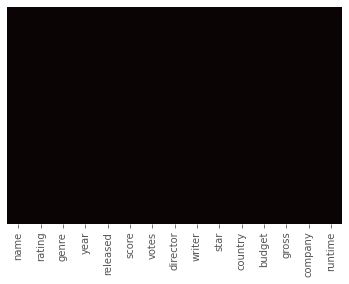

In [813]:
def list_missing(df):
    print('feature - % missing')
    print('-'*50)
    for col in df.columns:
        percent_missing = np.mean(df[col].isnull())
        print(f'{col} - {percent_missing*100:.2f}%')
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='mako')
    plt.show()

list_missing(df)

# Distinct Value Counts


In [814]:
print('Unique Counts')
unique_counts = df.drop(columns=numeric_features).nunique(axis=0).sort_values()
very_unique_cols = unique_counts[unique_counts > 60].index

print(unique_counts)

Unique Counts
rating         9
genre         15
country       57
company     2235
star        2646
director    2812
released    3288
writer      4348
name        7259
dtype: int64


Non numeric features with high distinct value counts can be troublesome with converted to dummy variables

# Preprocessing

In [815]:
df_no_preprocessing = df.copy() # save off a copy of the data prior to preprocessing

### Handle Initial Data Cleaning

In [816]:
# rename gross to avoid confusion
df.rename(columns = {'gross' : 'gross_revenue'}, inplace=True)

In [817]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


In [818]:
# split released into columns for month, day, year

# split released
df[['release_month', 'release_day', 'release_year', 'other']] = df['released'].str.split(' ', n=3, expand=True)

df['release_day'] = df['release_day'].str.replace(',','') # loose the , in day and make it at int
# some of the values in 'released' are not full dates... drop those
months = ['June', 'July', 'May', 'December', 'October', 'September',
    'February', 'April', 'August', 'March', 'November', 'January']

df = df[df['release_month'].isin(months)]
df = df[df['release_day'].astype(int) <= 31]

df['release_day'] = df['release_day'].astype(int)
df['release_year'] = df['release_year'].astype(int)



In [819]:
# add other columns that are release date related

# rebuild a valid 'release date' column
from time import strptime
df['release_month_num'] = [strptime(str(x), '%B').tm_mon for x in df['release_month']]
df['release_date'] = pd.to_datetime(df['release_month_num'].astype(str) +'-'+ df['release_day'].astype(str) +'-'+ df['release_year'].astype(str))

# add a 'release quater' column
df['release_quarter'] = (df['release_month_num'].astype(int)-1)//3 + 1

# add 'release day of week' column
df['release_day_of_week'] = df['release_date'].dt.day_name()

# show that all release date related attributes are valid
print(df['release_day_of_week'].unique())
print(df['release_day'].unique())
print(df['release_year'].unique())

# show that quarter values are correctly mapped to months
print(df.groupby(['release_month_num', 'release_month','release_quarter']).size().reset_index().rename(columns={0:'count'}))


['Friday' 'Wednesday' 'Tuesday' 'Thursday' 'Saturday' 'Sunday' 'Monday']
[13  2 20 25  9 19 16 17 26 12  3  8 15 24  1 10 30 27 11 28 21  6 18 31
 14 22  4  5 23 29  7]
[1980 1981 1984 1983 1982 1987 1985 1986 1990 1988 1992 1989 1991 1999
 1994 1993 1995 2001 1996 2000 1997 1998 2002 2003 2004 2014 2005 2006
 2007 2008 2010 2009 2013 2011 2016 2015 2012 2017 2018 2019 2020]
    release_month_num release_month  release_quarter  count
0                   1       January                1    574
1                   2      February                1    580
2                   3         March                1    660
3                   4         April                2    621
4                   5           May                2    551
5                   6          June                2    544
6                   7          July                3    566
7                   8        August                3    713
8                   9     September                3    631
9                  10 

In [820]:
# Add a title field that has the release year appended to name

df['title'] = df['name'] + ' (' + df['release_year'].astype(str) + ')'

In [821]:
# Add Gross Profit etc
df['gross_profit'] = df['gross_revenue'] - df['budget']
df['profit_margin'] = df['gross_profit'] / df['budget']
df['profit_multiple'] = df['gross_revenue'] / df['budget']

In [822]:
# inspect final cleansed data
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


### Handle Missing Values
TODO: Currently missing values are handled in Moy's preprocessing script and we're using output as this script's input

### Imput the average budget for the same genre and release year


Before Imput
feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


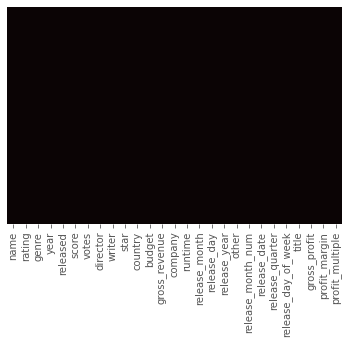

KeyError: 'release year'

In [823]:
# only has an impact if na's still exist
print('Before Imput')
list_missing(df)
df['budget'].fillna(df.groupby(['genre','release year'])['budget'].transform('mean'), inplace=True)
df['budget'].fillna(df.groupby(['release year'])['budget'].transform('mean'), inplace=True)
df['budget'].fillna(df.groupby(['genre'])['budget'].transform('mean'), inplace=True)
print('After Imput')
list_missing(df) 

### Last resort is to imput the overall budget mean or median

#### Is budget normally distributed?

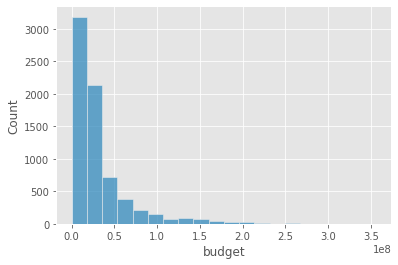

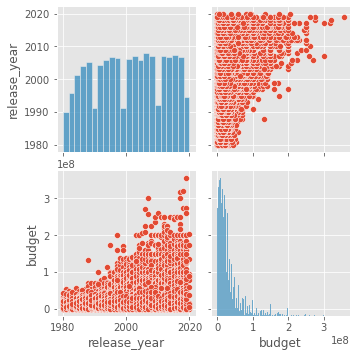

In [ ]:
df_missing_budget = df[df['budget'].isna()]
df_have_budget = df[df['budget'].notna()]
sns.histplot(df_have_budget, x='budget', bins=20)

cols_to_plot = ['release_year', 'budget', 'genre']
sns.pairplot(df_have_budget[cols_to_plot])
plt.show()

No budgets are not normally distributed therefore we should not imput the overall mean.

It also seems clear that budgets rise over time. Maybe imputing the average budget for the release year will work.

In [ ]:
df['budget'].fillna(df_have_budget['budget'].median(), inplace=True) # only has an impact if na's still exist

#### Drop any missing data rows that might still remain

feature - % missing
--------------------------------------------------
genre - 0.00%
score - 0.00%
budget - 0.00%
runtime - 0.00%
release_day - 0.00%
release_year - 0.00%
release_month_num - 0.00%
release_day_of_week - 0.00%


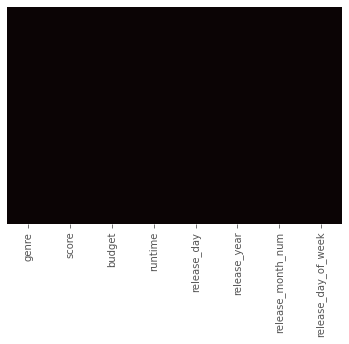

In [ ]:
# if we couldn't imput missing budget values then drop the column
if np.mean(df['budget'].isnull()) > 0:
    df = df.drop(columns=['budget'])

# Since there is a small % of missing data for the remaining columns, we will drop all rows with any null values
df = df.dropna(how='any',axis=0)

#double check and confirm there is NO null value in the data
list_missing(df)

### Handle Final Data Cleansing


In [ ]:
# Drop unwanted columns
try:
    df.drop(columns=['other', 'released', 'year'], inplace=True) #drop columns we don't need anymore
except:
    print('Nothing dropped. Columns referenced are not in the data. Have you already run this?')


Nothing dropped. Columns referenced are not in the data. Have you already run this?


In [ ]:
#Drop bad data
df = df.loc[df['budget'] >= 0] #budget can't be negative drop anything with a negative budget


In [ ]:
#Drop duplicates
df.drop_duplicates()

,name,rating,genre,score,votes,director,writer,star,country,budget,...,release_day,release_year,release_month_num,release_date,release_quarter,release_day_of_week,title,gross_profit,profit_margin,profit_multiple
0,The Shining,R,Drama,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,1.900000e+07,...,13,1980,6,1980-06-13,2,Friday,The Shining (1980),2.799877e+07,1.473620,2.473620
1,The Blue Lagoon,R,Adventure,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4.500000e+06,...,2,1980,7,1980-07-02,3,Wednesday,The Blue Lagoon (1980),5.435311e+07,12.078468,13.078468
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,1.800000e+07,...,20,1980,6,1980-06-20,2,Friday,Star Wars: Episode V - The Empire Strikes Back...,5.203751e+08,28.909726,29.909726
3,Airplane!,PG,Comedy,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3.500000e+06,...,2,1980,7,1980-07-02,3,Wednesday,Airplane! (1980),7.995354e+07,22.843868,23.843868
4,Caddyshack,R,Comedy,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6.000000e+06,...,25,1980,7,1980-07-25,3,Friday,Caddyshack (1980),3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7164,Wonder Woman 1984,PG-13,Action,5.4,217000.0,Patty Jenkins,Patty Jenkins,Gal Gadot,United States,9.129737e+07,...,25,2020,12,2020-12-25,4,Friday,Wonder Woman 1984 (2020),7.523666e+07,0.824084,1.824084
7165,Onward,PG,Animation,7.4,120000.0,Dan Scanlon,Dan Scanlon,Tom Holland,United States,5.895435e+07,...,6,2020,3,2020-03-06,1,Friday,Onward (2020),8.299626e+07,1.407805,2.407805
7166,The Quarry,R,Crime,5.4,2400.0,Scott Teems,Scott Teems,Shea Whigham,United States,1.502372e+07,...,17,2020,4,2020-04-17,2,Friday,The Quarry (2020),-1.502006e+07,-0.999756,0.000244
7167,Tulsa,PG-13,Comedy,5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,United States,3.800552e+07,...,3,2020,6,2020-06-03,2,Wednesday,Tulsa (2020),-3.759214e+07,-0.989123,0.010877


In [ ]:
# inspect data one last time
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson
country,United Kingdom
budget,19000000.0


In [ ]:
df_preprocessed = df.copy() # save off a copy of the data after preprocessing (this should be the data to be used for data viz)
#df_preprocessed.to_csv('preprocessing_done.csv')

# Feature Selection

### Drop very unique non-numeric columns

Categorical data with many unique values cause issues with converted to dummy variables

In [ ]:
df.drop(columns=very_unique_cols, inplace=True)
df

,rating,genre,score,votes,country,budget,gross_revenue,runtime,release_month,release_day,release_year,release_month_num,release_quarter,release_day_of_week,gross_profit,profit_margin,profit_multiple
0,R,Drama,8.4,927000.0,United Kingdom,1.900000e+07,46998772.0,146.0,June,13,1980,6,2,Friday,2.799877e+07,1.473620,2.473620
1,R,Adventure,5.8,65000.0,United States,4.500000e+06,58853106.0,104.0,July,2,1980,7,3,Wednesday,5.435311e+07,12.078468,13.078468
2,PG,Action,8.7,1200000.0,United States,1.800000e+07,538375067.0,124.0,June,20,1980,6,2,Friday,5.203751e+08,28.909726,29.909726
3,PG,Comedy,7.7,221000.0,United States,3.500000e+06,83453539.0,88.0,July,2,1980,7,3,Wednesday,7.995354e+07,22.843868,23.843868
4,R,Comedy,7.3,108000.0,United States,6.000000e+06,39846344.0,98.0,July,25,1980,7,3,Friday,3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7164,PG-13,Action,5.4,217000.0,United States,9.129737e+07,166534027.0,151.0,December,25,2020,12,4,Friday,7.523666e+07,0.824084,1.824084
7165,PG,Animation,7.4,120000.0,United States,5.895435e+07,141950608.0,102.0,March,6,2020,3,1,Friday,8.299626e+07,1.407805,2.407805
7166,R,Crime,5.4,2400.0,United States,1.502372e+07,3661.0,98.0,April,17,2020,4,2,Friday,-1.502006e+07,-0.999756,0.000244
7167,PG-13,Comedy,5.0,294.0,United States,3.800552e+07,413378.0,120.0,June,3,2020,6,2,Wednesday,-3.759214e+07,-0.989123,0.010877


### Correlation

Rule of thumb for strength of correlation [via statology](https://www.statology.org/what-is-a-strong-correlation/)

|Absolute value of r | Strength of relationship|
|----|----|
|r < 0.25 | No relationship|
|0.25 < r < 0.5 | Weak relationship|
|0.5 < r < 0.75 | Moderate relationship|
|r > 0.75 | Strong relationship|

In [ ]:
def correlation_analysis(df, method='pearson'):
    correlations = df.corr(method=method)
    
    # clustermap
    plt.figure(figsize=(14,12))
    sns.clustermap(correlations, cmap='mako_r', annot=True, vmin=0.25)
    plt.show()
    
    #pairplot
    #sns.pairplot(df, kind="reg", hue= outcome_var)

    # classify the correlations by rule of thumb
    corr_unpiv = correlations.melt(
        ignore_index=False, 
        var_name='var_2', 
        value_name='correlation').reset_index().rename(columns = {'index':'var_1'}).sort_values(by='correlation', ascending=False)
    corr_unpiv['correlation'] = abs(corr_unpiv['correlation'])
    corr_unpiv = corr_unpiv[corr_unpiv.var_1 != corr_unpiv.var_2] # don't want to show relationships with self
    corr_unpiv.drop_duplicates(subset='correlation', inplace=True) # drop rows the report the inverse duplicates <- not an optimal method

    strong = .75
    moderate = .50
    weak = .25
    corr_unpiv['relationship'] = 'Strong'
    corr_unpiv.loc[corr_unpiv['correlation'] < strong, 'relationship'] = 'Moderate'
    corr_unpiv.loc[corr_unpiv['correlation'] < moderate, 'relationship'] = 'Weak'
    corr_unpiv.loc[corr_unpiv['correlation'] < weak, 'relationship'] = 'None'

    strong = corr_unpiv[corr_unpiv['relationship'] == 'Strong']
    moderate = corr_unpiv[corr_unpiv['relationship'] == 'Moderate']
    weak = corr_unpiv[corr_unpiv['relationship'] == 'Weak']
    no_rel = corr_unpiv[corr_unpiv['relationship'] == 'None']
    print(strong)
    print('-'*75)
    print(moderate)
    print('-'*75)
    print(weak)
    print('-'*75)


<Figure size 1008x864 with 0 Axes>

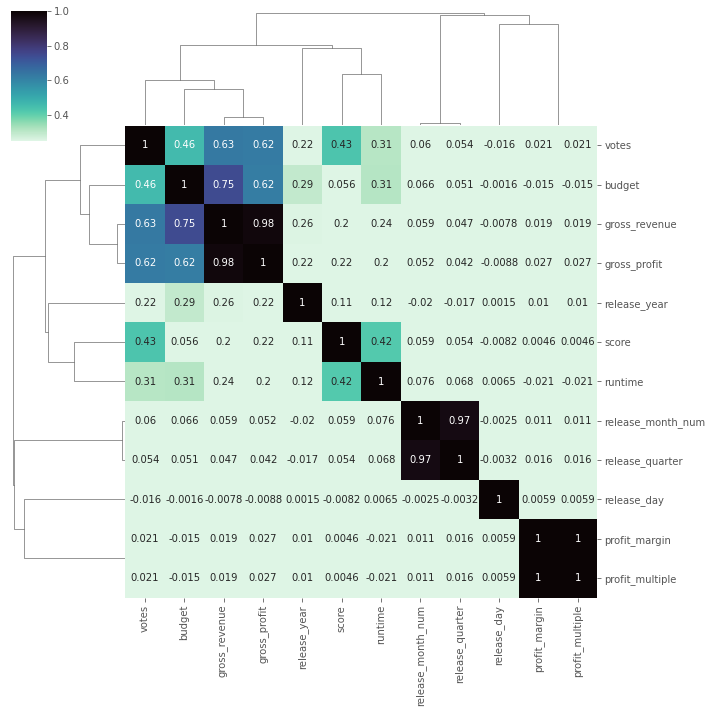

                 var_1            var_2  correlation relationship
142      profit_margin  profit_multiple     1.000000       Strong
45        gross_profit    gross_revenue     0.984493       Strong
103  release_month_num  release_quarter     0.971574       Strong
---------------------------------------------------------------------------
            var_1   var_2  correlation relationship
27  gross_revenue  budget     0.745110     Moderate
15  gross_revenue   votes     0.629913     Moderate
21   gross_profit   votes     0.623497     Moderate
33   gross_profit  budget     0.616558     Moderate
---------------------------------------------------------------------------
           var_1          var_2  correlation relationship
14        budget          votes     0.456610         Weak
12         score          votes     0.429991         Weak
48         score        runtime     0.418002         Weak
28       runtime         budget     0.310798         Weak
16       runtime          votes   

In [ ]:
correlation_analysis(df)

<Figure size 1008x864 with 0 Axes>

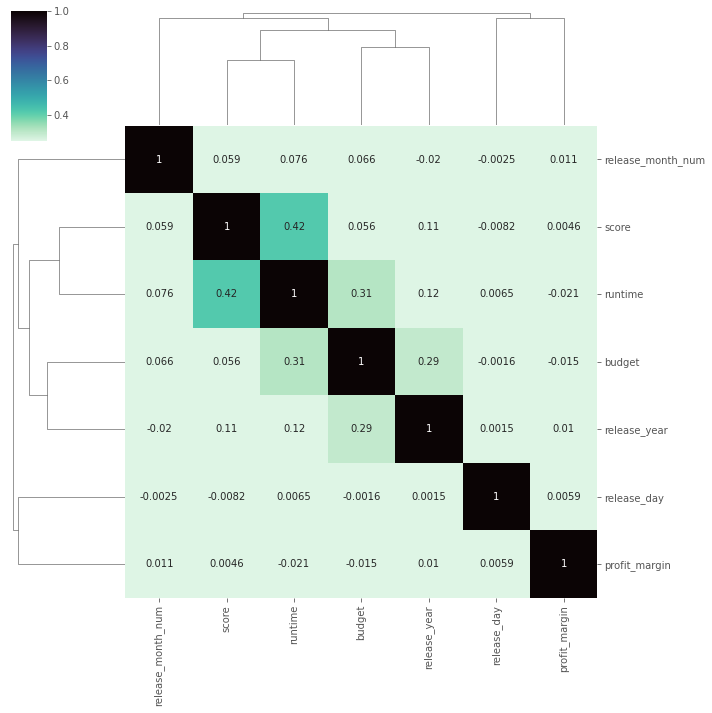

Empty DataFrame
Columns: [var_1, var_2, correlation, relationship]
Index: []
---------------------------------------------------------------------------
Empty DataFrame
Columns: [var_1, var_2, correlation, relationship]
Index: []
---------------------------------------------------------------------------
      var_1         var_2  correlation relationship
14    score       runtime     0.418002         Weak
9   runtime        budget     0.310798         Weak
29   budget  release_year     0.291328         Weak
---------------------------------------------------------------------------


In [ ]:
dropped_for_correlation = ['profit_multiple', 'gross_profit', 'release_month', 'release_quarter', 'gross_revenue', 'votes']

correlation_analysis(df.drop(columns=dropped_for_correlation))

In [ ]:
df.drop(columns=dropped_for_correlation, inplace=True) # commit to the drop
df

,rating,genre,score,country,budget,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,R,Drama,8.4,United Kingdom,1.900000e+07,146.0,13,1980,6,Friday,1.473620
1,R,Adventure,5.8,United States,4.500000e+06,104.0,2,1980,7,Wednesday,12.078468
2,PG,Action,8.7,United States,1.800000e+07,124.0,20,1980,6,Friday,28.909726
3,PG,Comedy,7.7,United States,3.500000e+06,88.0,2,1980,7,Wednesday,22.843868
4,R,Comedy,7.3,United States,6.000000e+06,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...,...,...
7164,PG-13,Action,5.4,United States,9.129737e+07,151.0,25,2020,12,Friday,0.824084
7165,PG,Animation,7.4,United States,5.895435e+07,102.0,6,2020,3,Friday,1.407805
7166,R,Crime,5.4,United States,1.502372e+07,98.0,17,2020,4,Friday,-0.999756
7167,PG-13,Comedy,5.0,United States,3.800552e+07,120.0,3,2020,6,Wednesday,-0.989123


We now have eliminated highly and moderately correlated features from our data.

### Multicollinearity

Calculate variance inflation factor (VIF)

[ref: statology](https://www.statology.org/how-to-calculate-vif-in-python/)

[ref: medium](https://medium.com/@analyttica/what-is-the-variance-inflation-factor-vif-d1dc12bb9cf5)

In [ ]:
def multicollinearity_analysis(df):
    # find design matrix
    tested_features = df.drop(columns=outcome_var_name).columns
    tested_features = '+'.join(tested_features)

    df_sample = df.sample(frac=1, replace=True, random_state=1) # this allows us to runs VIF on just a sample if the dataset and/or tested features list is large

    y, X = dmatrices(f'{outcome_var_name} ~ {tested_features}', data=df_sample, return_type='dataframe')

    # calculate VIF for each explanatory variable (LONG PROCESS)
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable'] = X.columns

    # view VIF for each explanatory variable 
    moderate_thresh = 1.5 # sometimes 2
    high_thresh = 5

    vif['degree'] = 'High'
    vif.loc[vif['VIF'] < high_thresh, 'degree'] = 'Moderate'
    vif.loc[vif['VIF'] < moderate_thresh, 'degree'] = 'Low'

    high_vif = vif[vif['degree'] == 'High']
    moderate_vif = vif[vif['degree'] == 'Moderate']
    low_vif = vif[vif['degree'] == 'Low']


    print(high_vif)
    print(moderate_vif)


In [ ]:
multicollinearity_analysis(df)

             VIF                   variable degree
0   43063.974065                  Intercept   High
3       8.448452               rating[T.PG]   High
4      13.519345            rating[T.PG-13]   High
5      15.942273                rating[T.R]   High
24     14.425439       country[T.Australia]   High
28     26.982203          country[T.Canada]   High
30      6.235355           country[T.China]   High
36     34.860205          country[T.France]   High
37     18.553825         country[T.Germany]   High
38      8.368929       country[T.Hong Kong]   High
41      9.322961           country[T.India]   High
44      7.705334         country[T.Ireland]   High
46      8.907815           country[T.Italy]   High
48     11.301650           country[T.Japan]   High
60      6.580919     country[T.South Korea]   High
61      8.547354           country[T.Spain]   High
68    113.108576  country[T.United Kingdom]   High
69    230.517943   country[T.United States]   High
         VIF                   

In [ ]:
dropped_for_multicollinearity = ['country', 'rating']

multicollinearity_analysis(df.drop(columns=dropped_for_multicollinearity))


            VIF   variable degree
0  37129.810525  Intercept   High
         VIF         variable    degree
4   1.874391  genre[T.Comedy]  Moderate
6   1.733961   genre[T.Drama]  Moderate
21  1.592989           budget  Moderate


In [ ]:
df.drop(columns=dropped_for_multicollinearity, inplace=True) # commit to the drop

In [ ]:
print(df.columns)
df

Index(['genre', 'score', 'budget', 'runtime', 'release_day', 'release_year',
       'release_month_num', 'release_day_of_week', 'profit_margin'],
      dtype='object')


,genre,score,budget,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,Drama,8.4,1.900000e+07,146.0,13,1980,6,Friday,1.473620
1,Adventure,5.8,4.500000e+06,104.0,2,1980,7,Wednesday,12.078468
2,Action,8.7,1.800000e+07,124.0,20,1980,6,Friday,28.909726
3,Comedy,7.7,3.500000e+06,88.0,2,1980,7,Wednesday,22.843868
4,Comedy,7.3,6.000000e+06,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...
7164,Action,5.4,9.129737e+07,151.0,25,2020,12,Friday,0.824084
7165,Animation,7.4,5.895435e+07,102.0,6,2020,3,Friday,1.407805
7166,Crime,5.4,1.502372e+07,98.0,17,2020,4,Friday,-0.999756
7167,Comedy,5.0,3.800552e+07,120.0,3,2020,6,Wednesday,-0.989123


We have now dropped highly multicollinear fields from our data

### Drop fields that can't be known at time of prediction

If the model is being used for the purpose of imputing missing data then skip this step.
But if it's intended to be used for new predictions, we can't provide it with data that doesn't exist yet.

In [ ]:
dropped_for_unknown_at_prediction = ['profit_margin']
df.drop(columns=dropped_for_unknown_at_prediction, inplace=True)
df

,genre,score,budget,runtime,release_day,release_year,release_month_num,release_day_of_week
0,Drama,8.4,1.900000e+07,146.0,13,1980,6,Friday
1,Adventure,5.8,4.500000e+06,104.0,2,1980,7,Wednesday
2,Action,8.7,1.800000e+07,124.0,20,1980,6,Friday
3,Comedy,7.7,3.500000e+06,88.0,2,1980,7,Wednesday
4,Comedy,7.3,6.000000e+06,98.0,25,1980,7,Friday
...,...,...,...,...,...,...,...,...
7164,Action,5.4,9.129737e+07,151.0,25,2020,12,Friday
7165,Animation,7.4,5.895435e+07,102.0,6,2020,3,Friday
7166,Crime,5.4,1.502372e+07,98.0,17,2020,4,Friday
7167,Comedy,5.0,3.800552e+07,120.0,3,2020,6,Wednesday


# Train Models

### Generate dummies

In [ ]:
X = pd.get_dummies(df.drop(columns=outcome_var_name), drop_first=True)
y = df[outcome_var_name]

### Noramalization

In [ ]:
# TODO: Broken

normalize = False # if classification(discrete variable) problem normalize=True, generally if regression(continuous variable) normalize=False

if normalize:
    X_df = df.drop(columns=[outcome_var_name])
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit(X_df)
    X = pd.DataFrame(scaler.transform(X_df), columns=df.drop(columns=[outcome_var_name]).columns)

### Split Data

In [ ]:
# partition data
test_size = 0.3
print(f'test size: {test_size}')
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=test_size, random_state=1)

test size: 0.3


### Define a list to collect the models

In [ ]:
all_models = {}

def model_performance(model, model_name, true_vals, pred_vals):
    #does not handle classification models
    model_dict = {
        'model_name': model_name,
        'explained_variance r^2': explained_var(true_vals, pred_vals),
        'mean_absolute_error': mae(true_vals, pred_vals),
        'mean_squared_error': mse(true_vals, pred_vals),
        'root_mean_squared_error': np.sqrt(mse(true_vals, pred_vals)),
        'mean_absolute_percentage_error': mape(true_vals, pred_vals),
        'model': model,
    }
    return model_dict

### Define a residual histogram method

In [ ]:
def residual_hist(model, valid_X, valid_y, bins=50):
    predicted = model.predict(valid_X)

    plt.title('Residuals')
    sns.histplot(valid_y - predicted, bins=bins)
    plt.show()

### Linear Regression

Table 6.3
intercept  -7.651059153658572
                        Predictor   coefficient
0                          budget -3.124026e-09
1                         runtime  2.209175e-02
2                     release_day -1.438147e-03
3                    release_year  5.767195e-03
4               release_month_num  6.236256e-03
5                 genre_Adventure  1.304396e-01
6                 genre_Animation  1.068185e+00
7                 genre_Biography  5.179397e-01
8                    genre_Comedy  9.267362e-02
9                     genre_Crime  3.465276e-01
10                    genre_Drama  2.639000e-01
11                   genre_Family  3.872626e-01
12                  genre_Fantasy  8.525886e-02
13                   genre_Horror -2.172377e-01
14                  genre_Mystery  4.157664e-01
15                  genre_Romance  2.313683e-01
16                   genre_Sci-Fi  6.619766e-01
17                 genre_Thriller  9.488058e-02
18                  genre_Western -2.528640e-01


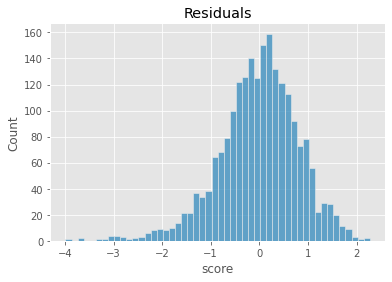

In [ ]:
if continuous:
    # fitting a regression model
    lm = LinearRegression(normalize=normalize) 
    lm.fit(train_X, train_y)

    # print performance measures

    # print coefficients
    print('Table 6.3')
    print('intercept ', lm.intercept_)
    print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

    # model stats
    regressionSummary(train_y, lm.predict(train_X))
    regressionSummary(valid_y, lm.predict(valid_X))

    # residuals
    residual_hist(lm, valid_X, valid_y)

    # add the model to our collection
    all_models[all_models.__len__()] = model_performance(lm,'Linear_Regression', valid_y, lm.predict(valid_X))

### Decision Tree


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.8396
            Mean Absolute Error (MAE) : 0.6430
          Mean Percentage Error (MPE) : -2.2393
Mean Absolute Percentage Error (MAPE) : 11.1541

Regression statistics

                      Mean Error (ME) : -0.0255
       Root Mean Squared Error (RMSE) : 0.8358
            Mean Absolute Error (MAE) : 0.6495
          Mean Percentage Error (MPE) : -2.5338
Mean Absolute Percentage Error (MAPE) : 11.1964


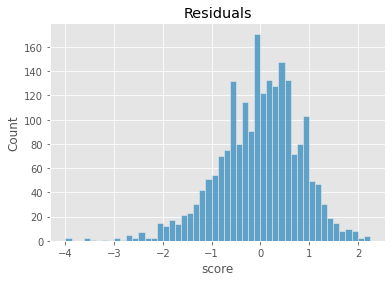

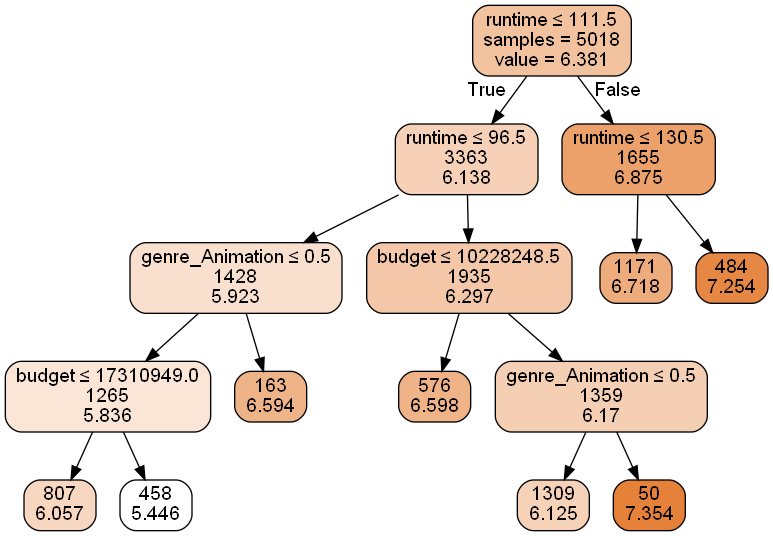

In [ ]:
depth = 4
min_split = 20
min_decr = 0.01

if continuous:
    dt = DecisionTreeRegressor(max_depth=depth, min_samples_split=min_split, min_impurity_decrease=min_decr)
    dt.fit(train_X, train_y)
    
    regressionSummary(train_y, dt.predict(train_X))
    regressionSummary(valid_y, dt.predict(valid_X))
else :
    dt = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split, min_impurity_decrease=min_decr)
    dt.fit(train_X, train_y)
    classificationSummary(train_y, dt.predict(train_X))
    classificationSummary(valid_y, dt.predict(valid_X))

# residuals
residual_hist(dt, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(dt,'Decision_Tree', valid_y, dt.predict(valid_X))

plotDecisionTree(dt, feature_names=train_X.columns)

### Random Forest


Regression statistics

                      Mean Error (ME) : 0.0019
       Root Mean Squared Error (RMSE) : 0.7343
            Mean Absolute Error (MAE) : 0.5573
          Mean Percentage Error (MPE) : -1.8739
Mean Absolute Percentage Error (MAPE) : 9.6855

Regression statistics

                      Mean Error (ME) : -0.0264
       Root Mean Squared Error (RMSE) : 0.7914
            Mean Absolute Error (MAE) : 0.6062
          Mean Percentage Error (MPE) : -2.3774
Mean Absolute Percentage Error (MAPE) : 10.4626


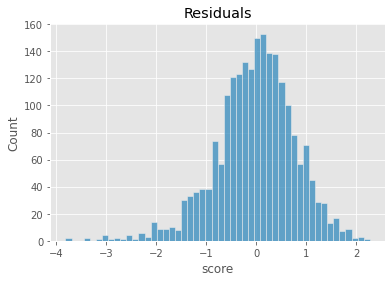

In [ ]:
depth = 7
n = 100

if continuous:
    rf = RandomForestRegressor(n_estimators=n,max_depth=depth)
    rf.fit(train_X, train_y)
    regressionSummary(train_y, rf.predict(train_X))
    regressionSummary(valid_y, rf.predict(valid_X))
else: 
    rf = RandomForestClassifier(n_estimators=n,max_depth=depth)
    rf.fit(train_X, train_y)
    classificationSummary(train_y, rf.predict(train_X))
    classificationSummary(valid_y, rf.predict(valid_X))

# residuals
residual_hist(rf, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(rf,'Random_Forest', valid_y, rf.predict(valid_X))

### AdaBoost


Regression statistics

                      Mean Error (ME) : 0.0773
       Root Mean Squared Error (RMSE) : 0.6181
            Mean Absolute Error (MAE) : 0.5186
          Mean Percentage Error (MPE) : -0.0875
Mean Absolute Percentage Error (MAPE) : 8.5299

Regression statistics

                      Mean Error (ME) : 0.0526
       Root Mean Squared Error (RMSE) : 0.8138
            Mean Absolute Error (MAE) : 0.6297
          Mean Percentage Error (MPE) : -1.0646
Mean Absolute Percentage Error (MAPE) : 10.6642


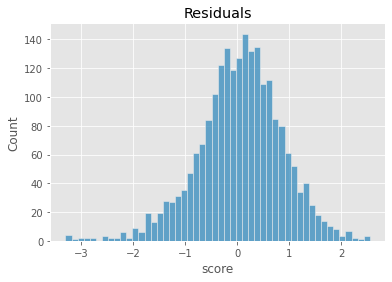

In [ ]:
depth = 8
n = 100

if continuous:
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth), n_estimators=n)
    ada.fit(train_X, train_y)
    regressionSummary(train_y, ada.predict(train_X))
    regressionSummary(valid_y, ada.predict(valid_X))
else:
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=n)
    ada.fit(train_X, train_y)
    classificationSummary(train_y, ada.predict(train_X))
    classificationSummary(valid_y, ada.predict(valid_X))

# residuals
residual_hist(ada, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(ada,'Ada_Boost', valid_y, ada.predict(valid_X))

### XGBoost


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.5769
            Mean Absolute Error (MAE) : 0.4362
          Mean Percentage Error (MPE) : -1.3372
Mean Absolute Percentage Error (MAPE) : 7.4864

Regression statistics

                      Mean Error (ME) : -0.0260
       Root Mean Squared Error (RMSE) : 0.8231
            Mean Absolute Error (MAE) : 0.6310
          Mean Percentage Error (MPE) : -2.2844
Mean Absolute Percentage Error (MAPE) : 10.8095


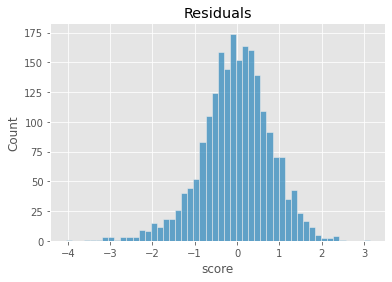

In [ ]:
gamma = 0.7
use_label_encoder = False

if continuous:
    xgb = XGBRegressor(gamma=gamma, use_label_encoder=use_label_encoder)
    xgb.fit(train_X, train_y)
    regressionSummary(train_y, xgb.predict(train_X))
    regressionSummary(valid_y, xgb.predict(valid_X))
else:
    xgb = XGBClassifier(use_label_encoder=use_label_encoder)
    xgb.fit(train_X, train_y)
    classificationSummary(train_y, xgb.predict(train_X))
    classificationSummary(valid_y, xgb.predict(valid_X))

# residuals
residual_hist(xgb, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(xgb,'XG_Boost', valid_y, xgb.predict(valid_X))

### Gradient Boost


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.7651
            Mean Absolute Error (MAE) : 0.5764
          Mean Percentage Error (MPE) : -2.0047
Mean Absolute Percentage Error (MAPE) : 10.0414

Regression statistics

                      Mean Error (ME) : -0.0284
       Root Mean Squared Error (RMSE) : 0.7827
            Mean Absolute Error (MAE) : 0.6017
          Mean Percentage Error (MPE) : -2.3921
Mean Absolute Percentage Error (MAPE) : 10.3869


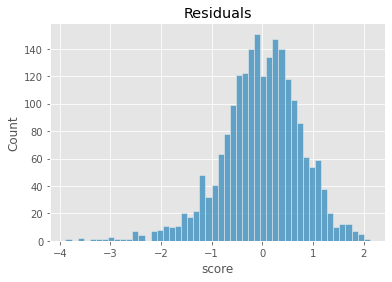

In [ ]:
if continuous:
    gb = GradientBoostingRegressor()
    gb.fit(train_X, train_y)
    regressionSummary(train_y, gb.predict(train_X))
    regressionSummary(valid_y, gb.predict(valid_X))
else:
    gb = GradientBoostingClassifier()
    gb.fit(train_X, train_y)
    classificationSummary(train_y, gb.predict(train_X))
    classificationSummary(valid_y, gb.predict(valid_X))

# residuals
residual_hist(gb, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(gb,'Gradient_Boost', valid_y, gb.predict(valid_X))

### knn

See [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for details on scoring options.

{'n_neighbors': 19, 'weights': 'uniform'}

Regression statistics

                      Mean Error (ME) : 0.0275
       Root Mean Squared Error (RMSE) : 0.8641
            Mean Absolute Error (MAE) : 0.6685
          Mean Percentage Error (MPE) : -1.9649
Mean Absolute Percentage Error (MAPE) : 11.5027

Regression statistics

                      Mean Error (ME) : -0.0099
       Root Mean Squared Error (RMSE) : 0.9020
            Mean Absolute Error (MAE) : 0.6993
          Mean Percentage Error (MPE) : -2.5966
Mean Absolute Percentage Error (MAPE) : 12.0273


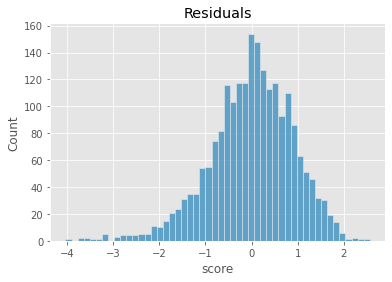

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

grid_params ={'n_neighbors':range(15, 30),
              'weights':['uniform','distance']}
cv = 5 # cross-validation splitting strategy 5-fold cross validation is the default
n_jobs = -1 # number of jobs to run in parallel -1 means use all of your processors

if continuous:
    scoring = 'neg_mean_absolute_percentage_error'
    gs = GridSearchCV(KNeighborsRegressor(),grid_params,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    knn= gs.best_estimator_

    regressionSummary(train_y, knn.predict(train_X))
    regressionSummary(valid_y, knn.predict(valid_X))
else:
    scoring='accuracy'
    gs = GridSearchCV(KNeighborsClassifier(),grid_params,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    knn= gs.best_estimator_

    classificationSummary(train_y, knn.predict(train_X))
    classificationSummary(valid_y, knn.predict(valid_X))

# residuals
residual_hist(knn, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(knn,'kNearest_Neighbor', valid_y, knn.predict(valid_X))

### Neural Net


Regression statistics

                      Mean Error (ME) : 0.0136
       Root Mean Squared Error (RMSE) : 0.9670
            Mean Absolute Error (MAE) : 0.7515
          Mean Percentage Error (MPE) : -2.6627
Mean Absolute Percentage Error (MAPE) : 12.9976

Regression statistics

                      Mean Error (ME) : -0.0014
       Root Mean Squared Error (RMSE) : 0.9518
            Mean Absolute Error (MAE) : 0.7451
          Mean Percentage Error (MPE) : -2.7745
Mean Absolute Percentage Error (MAPE) : 12.8305


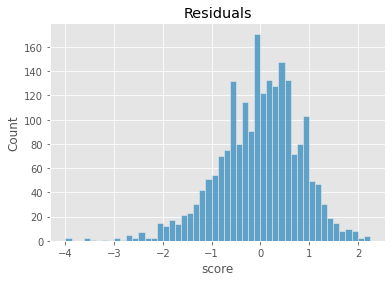

In [ ]:
# Neural net
hidden_layers = 2
activation = 'tanh' #logistic' (sigmoid), 'identity', 'tanh', 'relu'
solver = 'adam' # 'lbfgs', 'sgd', 'adam'
random_state = 1 # default=None
max_iter = 1000 # default=200
alpha = 0.0001 # default=0.0001

if continuous:
    nn = MLPRegressor(hidden_layer_sizes=(hidden_layers), activation=activation, solver=solver, random_state=random_state, max_iter=max_iter, alpha=alpha) 
    nn.fit(train_X, train_y)

    regressionSummary(train_y, nn.predict(train_X))
    regressionSummary(valid_y, nn.predict(valid_X))
else:
    nn = MLPClassifier(hidden_layer_sizes=(hidden_layers), activation=activation, solver=solver, random_state=random_state, max_iter=max_iter, alpha=alpha)
    nn.fit(train_X, train_y)

    classificationSummary(train_y, nn.predict(train_X))
    classificationSummary(valid_y, nn.predict(valid_X))

# residuals
residual_hist(nn, valid_X, valid_y)

# add the model to our collection
all_models[all_models.__len__()] = model_performance(nn,'Neural_Net', valid_y, nn.predict(valid_X))

# Select Model


In [ ]:
df_models = pd.DataFrame(all_models).T
df_models.sort_values(by='mean_absolute_percentage_error')


,model_name,explained_variance r^2,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,model
5,Gradient_Boost,0.324658,0.601841,0.612534,0.782645,0.10387,([DecisionTreeRegressor(criterion='friedman_ms...
2,Random_Forest,0.310591,0.605731,0.625391,0.790817,0.104599,"(DecisionTreeRegressor(max_depth=7, max_featur..."
3,Ada_Boost,0.26165,0.635129,0.672449,0.82003,0.107419,"(DecisionTreeRegressor(max_depth=8, random_sta..."
4,XG_Boost,0.252895,0.631003,0.677436,0.823065,0.108095,"XGBRegressor(base_score=0.5, booster='gbtree',..."
0,Linear_Regression,0.256697,0.630974,0.673698,0.820791,0.109145,LinearRegression()
1,Decision_Tree,0.229584,0.649506,0.698524,0.835777,0.111964,"DecisionTreeRegressor(max_depth=4, min_impurit..."
6,kNearest_Neighbor,0.102015,0.699332,0.813529,0.901958,0.120273,KNeighborsRegressor(n_neighbors=19)
7,Neural_Net,-0.0,0.745081,0.905842,0.951757,0.128305,"MLPRegressor(activation='tanh', hidden_layer_s..."


In [ ]:
selected_model = df_models[df_models['model_name'] == 'Gradient_Boost']['model'].values[0] # select gradient_boost based on lowest mape

# Tune Model

### Make Predictions on Validation Data


Regression statistics

                      Mean Error (ME) : -0.0283
       Root Mean Squared Error (RMSE) : 0.7828
            Mean Absolute Error (MAE) : 0.6019
          Mean Percentage Error (MPE) : -2.3913
Mean Absolute Percentage Error (MAPE) : 10.3894


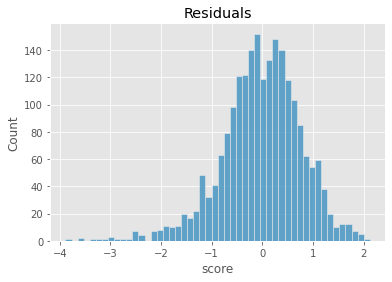

First few results
      Predicted  Actual  Residual
4332   6.579765     7.0  0.420235
1117   6.184284     6.5  0.315716
4492   6.455570     5.7 -0.755570
7107   6.275719     6.3  0.024281
1475   6.199146     6.3  0.100854
6908   5.702916     6.7  0.997084
462    5.360133     5.8  0.439867
6392   6.758646     7.1  0.341354
5083   6.033645     5.8 -0.233645
2684   6.782856     6.1 -0.682856
3709   6.412972     7.0  0.587028
1558   6.978144     7.6  0.621856
1651   7.055669     7.5  0.444331
299    5.897545     5.7 -0.197545
447    5.819725     4.7 -1.119725
325    6.143009     6.4  0.256991
4286   6.676642     6.2 -0.476642
6842   6.597282     7.0  0.402718
1877   6.222704     5.8 -0.422704
758    5.936300     5.9 -0.036300


In [ ]:
# Use predict() to make predictions on a new set
selected_model_pred = selected_model.predict(valid_X)
result = pd.DataFrame({'Predicted': selected_model_pred, 'Actual': valid_y, 'Residual': valid_y - selected_model_pred})

# print performance measures
regressionSummary(valid_y, selected_model_pred)

residual_hist(selected_model, valid_X, valid_y)

print('First few results')
print(result.head(20))

# Make a totally new prediction

In [ ]:
# create a movie (in this data a movie can't have more than one rating nor more than one genre)
newMovie = pd.DataFrame([{
    'budget': 1_000_000,
    'runtime': 3*60,
    'release_day': 15,
    'release_year': 2022,
    'release_month_num': 6,
    'genre_Adventure': 0,
    'genre_Animation': 0,
    'genre_Biography': 0,
    'genre_Comedy': 0,
    'genre_Crime': 0,
    'genre_Drama': 0,
    'genre_Family': 0,
    'genre_Fantasy': 0,
    'genre_Horror': 1,
    'genre_Mystery': 0,
    'genre_Romance': 0,
    'genre_Sci-Fi': 0,
    'genre_Thriller': 0,
    'genre_Western': 0,
    'genre_Music': 0,
    'genre_Musical': 0,
    'genre_Sport': 0,
    'release_day_of_week_Monday': 0, 
    'release_day_of_week_Saturday': 0, 
    'release_day_of_week_Sunday': 0, 
    'release_day_of_week_Thursday': 0, 
    'release_day_of_week_Tuesday': 0, 
    'release_day_of_week_Wednesday': 1
}])

newMovie_thin = newMovie.loc[:, ~(newMovie == 0).any()]

# predict it's score
print(f'What score do we expect from a new movie with the following features?\n{newMovie_thin.T}\n')
print(f'{outcome_var_name}: {selected_model.predict(newMovie[X.columns])}')


What score do we expect from a new movie with the following features?
                                     0
budget                         1000000
runtime                            180
release_day                         15
release_year                      2022
release_month_num                    6
genre_Horror                         1
release_day_of_week_Wednesday        1

score: [7.87557517]
